In [1]:
import pandas as pd
import os
import xarray as xr
import numpy as np
import datetime as dt
import math

import matplotlib.pyplot as plt
import matplotlib as mpl

import geopandas as gpd # To get HBL tile IDs

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

In [2]:
# from dask.distributed import LocalCluster

# cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing
# client = cluster.get_client()
# client # Can open in other window by clicking 'Dashboard' link below

# Setup

In [3]:
winterYear_tile = 'F:/HLS/Canada/Tiles60km/snowDynamics_fmask_v1/winterYear/' # winterYear tiled products

In [4]:
tile = 904
tile_stats = pd.read_csv(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\IMS (1 km)\Outputs\tiles_IMS_SnowDynamics4HLS.csv", index_col = 0)
tile_stats.iloc[904]

smin_avg        226.428570
smax_avg         41.166668
sstart_avg      -66.000000
send_avg        151.833330
send_last       156.000000
sstart_first    279.000000
Name: 904, dtype: float64

In [5]:
snowDynamics = xr.open_mfdataset(winterYear_tile + str(tile) + '/*.nc', engine = 'netcdf4').compute()
snowDynamics

<xarray.Dataset> Size: 577MB
Dimensions:        (winterYear: 6, y: 2001, x: 2001)
Coordinates:
  * winterYear     (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
  * x              (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y              (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref    int64 8B 0
Data variables:
    snow_start     (winterYear, y, x) float32 96MB -100.0 -100.0 ... -66.0 -66.0
    snow_end       (winterYear, y, x) float32 96MB 131.0 131.0 ... 125.0 125.0
    snow_length    (winterYear, y, x) uint16 48MB 232 232 168 ... 192 192 192
    snow_periods   (winterYear, y, x) uint8 24MB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    snow_status    (winterYear, y, x) uint8 24MB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    snow_start_u   (winterYear, y, x) float32 96MB 13.5 13.5 77.0 ... 7.0 7.5
    snow_end_u     (winterYear, y, x) float32 96MB 7.0 7.0 7.0 ... 4.5 4.5 4.5
    snow_length_u  (winterYear, y, x) float32 96MB 20.5 20.5 84.0 ... 11.5 12.0

In [6]:
implausible_snow = [int(tile_stats.loc[tile, 'send_last']) + 7, int(tile_stats.loc[tile, 'sstart_first']) - 7]
implausible_snow

[163, 272]

# Work through interannualSnowDynamics()

In [7]:
min_count = math.ceil(snowDynamics.sizes['winterYear'] / 2)
min_count

3

In [8]:
valid_count = snowDynamics['snow_end'].notnull().sum(dim = 'winterYear') # Number of valid values per pixel
valid_count

<xarray.DataArray 'snow_end' (y: 2001, x: 2001)> Size: 32MB
array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]])
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0

In [9]:
#valid_count.plot.hist() # All 5s

In [10]:
end = xr.where(valid_count >= min_count, snowDynamics['snow_end'], np.nan) # Filter by valid_count
end

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 96MB
array([[[131., 142., 133., 135., 146., 126.],
        [131., 142., 129., 135., 146., 126.],
        [131., 146., 132., 135., 139., 126.],
        ...,
        [152., 134., 124., 136., 142., 125.],
        [152., 134., 124., 136., 142., 125.],
        [152., 134., 124., 136., 136., 125.]],

       [[131., 130., 127., 135., 139., 126.],
        [131., 130., 124., 135., 139., 126.],
        [131., 146., 132., 135., 139., 126.],
        ...,
        [152., 134., 138., 136., 142., 125.],
        [152., 134., 124., 136., 142., 125.],
        [152., 134., 124., 136., 142., 125.]],

       [[131., 130., 124., 135., 139., 126.],
        [131., 146., 124., 135., 139., 126.],
        [131., 146., 132., 135., 139., 126.],
        ...,
...
        ...,
        [130., 140., 121., 133., 136., 125.],
        [130., 140., 121., 133., 136., 125.],
        [130., 140., 121., 133., 136., 125.]],

       [[136., 147., 126., 131., 136., 125.],
        [136., 147., 126., 131., 143., 125.],
        [136., 147., 131., 131., 143., 125.],
        ...,
        [137., 140., 127., 133., 136., 125.],
        [137., 140., 127., 133., 136., 125.],
        [137., 140., 127., 133., 136., 125.]],

       [[136., 147., 126., 131., 143., 125.],
        [136., 147., 126., 131., 143., 125.],
        [136., 147., 126., 131., 143., 125.],
        ...,
        [137., 140., 127., 133., 136., 125.],
        [137., 140., 127., 133., 136., 125.],
        [137., 140., 127., 133., 136., 125.]]], dtype=float32)
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

In [11]:
u_days = xr.where(snowDynamics['snow_end'].notnull(), snowDynamics['snow_end_u'], np.nan)
u_days

<xarray.DataArray (winterYear: 6, y: 2001, x: 2001)> Size: 96MB
array([[[ 7. ,  7. ,  7. , ..., 18. , 18. , 18. ],
        [ 7. ,  7. ,  7. , ..., 18. , 18. , 18. ],
        [ 7. ,  7. ,  7. , ..., 18. , 18. , 18. ],
        ...,
        [ 3. ,  4.5,  4.5, ...,  3.5,  3.5,  3.5],
        [ 4.5,  4.5,  4.5, ...,  3. ,  3. ,  3. ],
        [ 4.5,  4.5,  4.5, ...,  3. ,  3. ,  3. ]],

       [[ 3. ,  3. ,  7. , ..., 11. , 11. , 11. ],
        [ 8.5,  8.5,  7. , ..., 11. , 11. , 11. ],
        [ 8.5,  7. ,  7. , ..., 11. , 11. , 11. ],
        ...,
        [ 2. ,  8. ,  8. , ...,  0.5,  0.5,  0.5],
        [ 8. ,  8. ,  8. , ...,  0.5,  0.5,  0.5],
        [ 8. ,  8. ,  8. , ...,  0.5,  0.5,  0.5]],

       [[ 9.5, 13. ,  0. , ...,  8. ,  8. ,  8. ],
        [ 4. ,  7.5,  0. , ...,  4.5,  8. ,  8. ],
        [ 7.5,  7.5,  0. , ...,  8. ,  8. ,  8. ],
        ...,
...
        ...,
        [ 3. ,  3. ,  3. , ...,  4.5,  4.5,  4.5],
        [ 3. ,  3. ,  3. , ...,  4.5,  4.5,  4.5],
        [ 3. ,  3. ,  3. , ...,  4.5,  4.5,  4.5]],

       [[ 1. ,  1. ,  5.5, ...,  2.5,  2.5,  2.5],
        [ 5.5,  5.5,  5.5, ...,  2.5,  2.5,  2.5],
        [ 5.5,  5.5,  5.5, ...,  2.5,  4. ,  4. ],
        ...,
        [ 2.5,  2.5,  4. , ...,  2.5,  2.5,  2.5],
        [ 2.5,  4. ,  4. , ...,  2.5,  2.5,  2.5],
        [ 4. ,  4. ,  4. , ...,  2.5,  2.5,  2.5]],

       [[ 3. ,  3. ,  3. , ...,  4.5,  4.5,  4.5],
        [ 3. ,  3. ,  3. , ...,  4.5,  4.5,  4.5],
        [ 3. ,  3. ,  3. , ...,  4.5,  4.5,  4.5],
        ...,
        [ 4.5,  4.5,  4.5, ...,  4.5,  4.5,  4.5],
        [ 4.5,  4.5,  4.5, ...,  4.5,  4.5,  4.5],
        [ 4.5,  4.5,  4.5, ...,  4.5,  4.5,  4.5]]], dtype=float32)
Coordinates:
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0

(array([9.078403e+06, 7.556383e+06, 6.848479e+06, 2.523420e+05,
        2.207720e+05, 5.906900e+04, 7.482000e+03, 1.052000e+03,
        1.900000e+01, 5.000000e+00]),
 array([ 0.        ,  3.3499999 ,  6.69999981, 10.04999924, 13.39999962,
        16.75      , 20.09999847, 23.44999886, 26.79999924, 30.14999962,
        33.5       ]),
 <BarContainer object of 10 artists>)

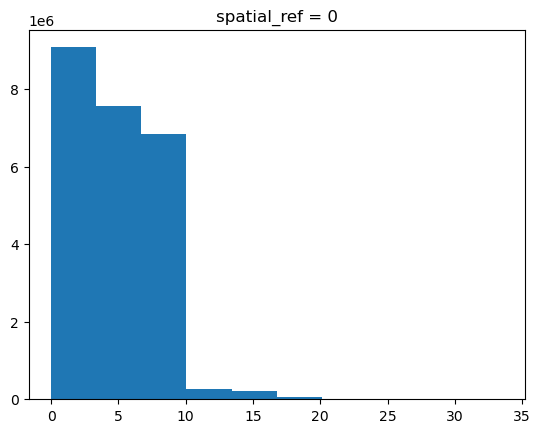

In [12]:
u_days.plot.hist()

In [13]:
u_weight = 2.718 ** (-0.046 * snowDynamics['snow_end_u']) # -0.046 means 50% weight on 15, exponential
u_weight

<xarray.DataArray 'snow_end_u' (winterYear: 6, y: 2001, x: 2001)> Size: 96MB
array([[[0.7247224 , 0.7247224 , 0.7247224 , ..., 0.43695977,
         0.43695977, 0.43695977],
        [0.7247224 , 0.7247224 , 0.7247224 , ..., 0.43695977,
         0.43695977, 0.43695977],
        [0.7247224 , 0.7247224 , 0.7247224 , ..., 0.43695977,
         0.43695977, 0.43695977],
        ...,
        [0.87111115, 0.8130371 , 0.8130371 , ..., 0.85130626,
         0.85130626, 0.85130626],
        [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.87111115,
         0.87111115, 0.87111115],
        [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.87111115,
         0.87111115, 0.87111115]],

       [[0.87111115, 0.87111115, 0.7247224 , ..., 0.602934  ,
         0.602934  , 0.602934  ],
        [0.6764076 , 0.6764076 , 0.7247224 , ..., 0.602934  ,
         0.602934  , 0.602934  ],
        [0.6764076 , 0.7247224 , 0.7247224 , ..., 0.602934  ,
         0.602934  , 0.602934  ],
...
        [0.8913768 , 0.8913768 , 0.8319517 , ..., 0.8913768 ,
         0.8913768 , 0.8913768 ],
        [0.8913768 , 0.8319517 , 0.8319517 , ..., 0.8913768 ,
         0.8913768 , 0.8913768 ],
        [0.8319517 , 0.8319517 , 0.8319517 , ..., 0.8913768 ,
         0.8913768 , 0.8913768 ]],

       [[0.87111115, 0.87111115, 0.87111115, ..., 0.8130371 ,
         0.8130371 , 0.8130371 ],
        [0.87111115, 0.87111115, 0.87111115, ..., 0.8130371 ,
         0.8130371 , 0.8130371 ],
        [0.87111115, 0.87111115, 0.87111115, ..., 0.8130371 ,
         0.8130371 , 0.8130371 ],
        ...,
        [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.8130371 ,
         0.8130371 , 0.8130371 ],
        [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.8130371 ,
         0.8130371 , 0.8130371 ],
        [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.8130371 ,
         0.8130371 , 0.8130371 ]]], dtype=float32)
Coordinates:
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0

(array([2.400000e+01, 7.490000e+03, 1.104100e+04, 2.376640e+05,
        2.568340e+05, 8.356100e+05, 6.662569e+06, 6.698470e+06,
        7.075202e+06, 2.239102e+06]),
 array([0.21420105, 0.29278094, 0.37136084, 0.44994074, 0.52852064,
        0.60710055, 0.68568039, 0.76426029, 0.84284019, 0.9214201 ,
        1.        ]),
 <BarContainer object of 10 artists>)

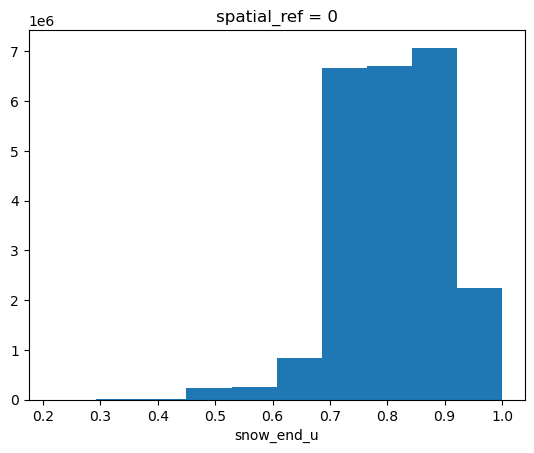

In [14]:
u_weight.plot.hist()

In [15]:
late_end = implausible_snow[0] # After this date = late end
late_end

163

In [16]:
early_end = int(end.quantile(0.05)) # Before this = early end
early_end

124

In [17]:
late_diff = end - late_end # Positive = After late end
late_diff

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 96MB
array([[[-32., -21., -30., -28., -17., -37.],
        [-32., -21., -34., -28., -17., -37.],
        [-32., -17., -31., -28., -24., -37.],
        ...,
        [-11., -29., -39., -27., -21., -38.],
        [-11., -29., -39., -27., -21., -38.],
        [-11., -29., -39., -27., -27., -38.]],

       [[-32., -33., -36., -28., -24., -37.],
        [-32., -33., -39., -28., -24., -37.],
        [-32., -17., -31., -28., -24., -37.],
        ...,
        [-11., -29., -25., -27., -21., -38.],
        [-11., -29., -39., -27., -21., -38.],
        [-11., -29., -39., -27., -21., -38.]],

       [[-32., -33., -39., -28., -24., -37.],
        [-32., -17., -39., -28., -24., -37.],
        [-32., -17., -31., -28., -24., -37.],
        ...,
...
        ...,
        [-33., -23., -42., -30., -27., -38.],
        [-33., -23., -42., -30., -27., -38.],
        [-33., -23., -42., -30., -27., -38.]],

       [[-27., -16., -37., -32., -27., -38.],
        [-27., -16., -37., -32., -20., -38.],
        [-27., -16., -32., -32., -20., -38.],
        ...,
        [-26., -23., -36., -30., -27., -38.],
        [-26., -23., -36., -30., -27., -38.],
        [-26., -23., -36., -30., -27., -38.]],

       [[-27., -16., -37., -32., -20., -38.],
        [-27., -16., -37., -32., -20., -38.],
        [-27., -16., -37., -32., -20., -38.],
        ...,
        [-26., -23., -36., -30., -27., -38.],
        [-26., -23., -36., -30., -27., -38.],
        [-26., -23., -36., -30., -27., -38.]]], dtype=float32)
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

In [18]:
early_diff = abs(end - early_end) # Negative (before abs) = Before early end
early_diff

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 96MB
array([[[ 7., 18.,  9., 11., 22.,  2.],
        [ 7., 18.,  5., 11., 22.,  2.],
        [ 7., 22.,  8., 11., 15.,  2.],
        ...,
        [28., 10.,  0., 12., 18.,  1.],
        [28., 10.,  0., 12., 18.,  1.],
        [28., 10.,  0., 12., 12.,  1.]],

       [[ 7.,  6.,  3., 11., 15.,  2.],
        [ 7.,  6.,  0., 11., 15.,  2.],
        [ 7., 22.,  8., 11., 15.,  2.],
        ...,
        [28., 10., 14., 12., 18.,  1.],
        [28., 10.,  0., 12., 18.,  1.],
        [28., 10.,  0., 12., 18.,  1.]],

       [[ 7.,  6.,  0., 11., 15.,  2.],
        [ 7., 22.,  0., 11., 15.,  2.],
        [ 7., 22.,  8., 11., 15.,  2.],
        ...,
...
        ...,
        [ 6., 16.,  3.,  9., 12.,  1.],
        [ 6., 16.,  3.,  9., 12.,  1.],
        [ 6., 16.,  3.,  9., 12.,  1.]],

       [[12., 23.,  2.,  7., 12.,  1.],
        [12., 23.,  2.,  7., 19.,  1.],
        [12., 23.,  7.,  7., 19.,  1.],
        ...,
        [13., 16.,  3.,  9., 12.,  1.],
        [13., 16.,  3.,  9., 12.,  1.],
        [13., 16.,  3.,  9., 12.,  1.]],

       [[12., 23.,  2.,  7., 19.,  1.],
        [12., 23.,  2.,  7., 19.,  1.],
        [12., 23.,  2.,  7., 19.,  1.],
        ...,
        [13., 16.,  3.,  9., 12.,  1.],
        [13., 16.,  3.,  9., 12.,  1.],
        [13., 16.,  3.,  9., 12.,  1.]]], dtype=float32)
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

In [19]:
i1_days = xr.where(end >= early_end, 0, early_diff) # Add early end days
i1_days = xr.where(end <= late_end, i1_days, late_diff) # Add late end days
i1_days

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 96MB
array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 3., 0., 0., 0.],
        [0., 0., 3., 0., 0., 0.],
        [0., 0., 3., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

(array([2.3559712e+07, 3.7282300e+05, 7.8079000e+04, 5.7030000e+03,
        3.6840000e+03, 3.9510000e+03, 2.0000000e+00, 0.0000000e+00,
        7.0000000e+00, 4.5000000e+01]),
 array([ 0.        ,  2.79999995,  5.5999999 ,  8.39999962, 11.19999981,
        14.        , 16.79999924, 19.60000038, 22.39999962, 25.19999886,
        28.        ]),
 <BarContainer object of 10 artists>)

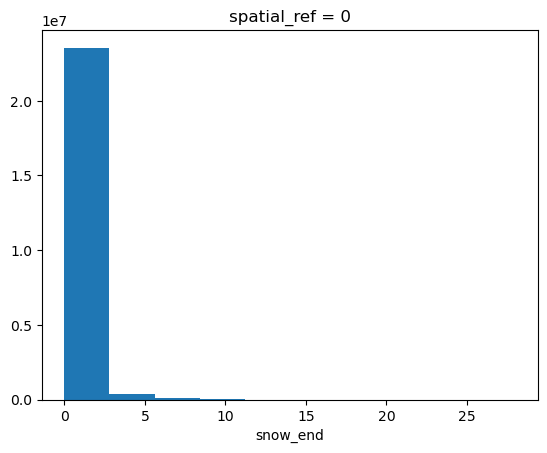

In [20]:
i1_days.plot.hist()

In [21]:
i1_weight = 2.718 ** (-0.046 * i1_days) # -0.046 means 50% weight on 15, exponential
i1_weight

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 96MB
array([[[1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ]],

       [[1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
...
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ]],

       [[1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ]]], dtype=float32)
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

(array([5.2000000e+01, 0.0000000e+00, 2.0000000e+00, 4.1330000e+03,
        7.7560000e+03, 1.5660000e+03, 7.7962000e+04, 1.0260900e+05,
        3.0796300e+05, 2.3521963e+07]),
 array([0.27585873, 0.34827286, 0.42068696, 0.49310109, 0.56551522,
        0.63792932, 0.71034348, 0.78275764, 0.85517168, 0.92758584,
        1.        ]),
 <BarContainer object of 10 artists>)

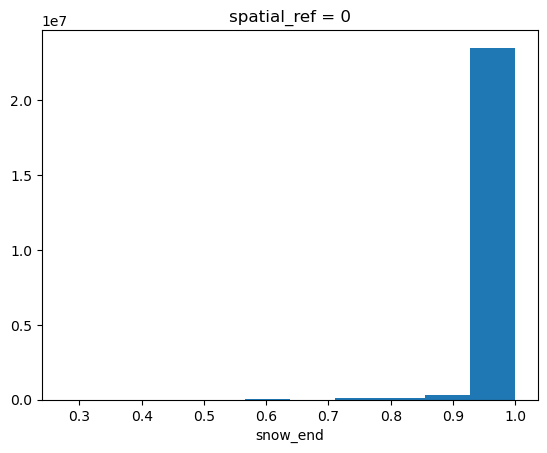

In [22]:
i1_weight.plot.hist()

In [23]:
i2_days = abs(end - end.median(dim = 'winterYear', skipna = True))
i2_days

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 192MB
array([[[ 3. ,  8. ,  1. ,  1. , 12. ,  8. ],
        [ 2. ,  9. ,  4. ,  2. , 13. ,  7. ],
        [ 2.5, 12.5,  1.5,  1.5,  5.5,  7.5],
        ...,
        [17. ,  1. , 11. ,  1. ,  7. , 10. ],
        [17. ,  1. , 11. ,  1. ,  7. , 10. ],
        [17. ,  1. , 11. ,  1. ,  1. , 10. ]],

       [[ 0.5,  0.5,  3.5,  4.5,  8.5,  4.5],
        [ 0.5,  0.5,  6.5,  4.5,  8.5,  4.5],
        [ 2.5, 12.5,  1.5,  1.5,  5.5,  7.5],
        ...,
        [15. ,  3. ,  1. ,  1. ,  5. , 12. ],
        [17. ,  1. , 11. ,  1. ,  7. , 10. ],
        [17. ,  1. , 11. ,  1. ,  7. , 10. ]],

       [[ 0.5,  0.5,  6.5,  4.5,  8.5,  4.5],
        [ 2. , 13. ,  9. ,  2. ,  6. ,  7. ],
        [ 2.5, 12.5,  1.5,  1.5,  5.5,  7.5],
        ...,
...
        ...,
        [ 1.5,  8.5, 10.5,  1.5,  4.5,  6.5],
        [ 1.5,  8.5, 10.5,  1.5,  4.5,  6.5],
        [ 1.5,  8.5, 10.5,  1.5,  4.5,  6.5]],

       [[ 2.5, 13.5,  7.5,  2.5,  2.5,  8.5],
        [ 2.5, 13.5,  7.5,  2.5,  9.5,  8.5],
        [ 2.5, 13.5,  2.5,  2.5,  9.5,  8.5],
        ...,
        [ 2.5,  5.5,  7.5,  1.5,  1.5,  9.5],
        [ 2.5,  5.5,  7.5,  1.5,  1.5,  9.5],
        [ 2.5,  5.5,  7.5,  1.5,  1.5,  9.5]],

       [[ 2.5, 13.5,  7.5,  2.5,  9.5,  8.5],
        [ 2.5, 13.5,  7.5,  2.5,  9.5,  8.5],
        [ 2.5, 13.5,  7.5,  2.5,  9.5,  8.5],
        ...,
        [ 2.5,  5.5,  7.5,  1.5,  1.5,  9.5],
        [ 2.5,  5.5,  7.5,  1.5,  1.5,  9.5],
        [ 2.5,  5.5,  7.5,  1.5,  1.5,  9.5]]])
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

(array([9.995369e+06, 8.465609e+06, 4.328400e+06, 1.084755e+06,
        1.412070e+05, 7.368000e+03, 1.065000e+03, 1.840000e+02,
        4.400000e+01, 5.000000e+00]),
 array([ 0.  ,  3.95,  7.9 , 11.85, 15.8 , 19.75, 23.7 , 27.65, 31.6 ,
        35.55, 39.5 ]),
 <BarContainer object of 10 artists>)

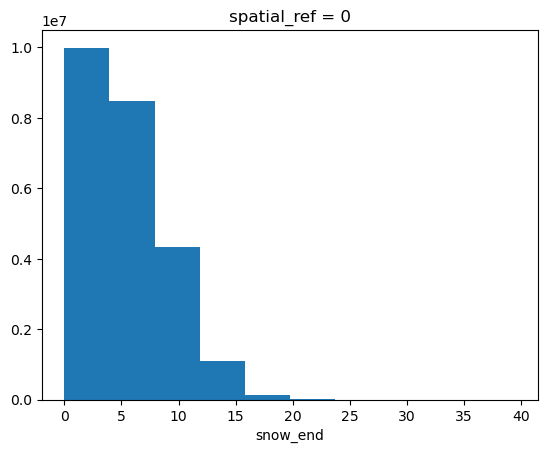

In [24]:
i2_days.plot.hist()

In [25]:
i2_weight = 2.718 ** (-0.046 * i2_days) # -0.046 mean 50% weight on 15, exponential  
i2_weight

<xarray.DataArray 'snow_end' (y: 2001, x: 2001, winterYear: 6)> Size: 192MB
array([[[0.87111116, 0.69214359, 0.95504652, 0.95504652, 0.57583002,
         0.69214359],
        [0.91211385, 0.66102933, 0.83195168, 0.91211385, 0.54994445,
         0.72472239],
        [0.89137677, 0.56273842, 0.93333336, 0.93333336, 0.77648825,
         0.70824569],
        ...,
        [0.45752721, 0.95504652, 0.602934  , 0.95504652, 0.72472239,
         0.63131376],
        [0.45752721, 0.95504652, 0.602934  , 0.95504652, 0.72472239,
         0.63131376],
        [0.45752721, 0.95504652, 0.602934  , 0.95504652, 0.95504652,
         0.63131376]],

       [[0.97726481, 0.97726481, 0.85130628, 0.8130371 , 0.67640758,
         0.8130371 ],
        [0.97726481, 0.97726481, 0.7415824 , 0.8130371 , 0.67640758,
         0.8130371 ],
        [0.89137677, 0.56273842, 0.93333336, 0.93333336, 0.77648825,
         0.70824569],
...
        [0.89137677, 0.77648825, 0.70824569, 0.93333336, 0.93333336,
         0.6460007 ],
        [0.89137677, 0.77648825, 0.70824569, 0.93333336, 0.93333336,
         0.6460007 ],
        [0.89137677, 0.77648825, 0.70824569, 0.93333336, 0.93333336,
         0.6460007 ]],

       [[0.89137677, 0.53744137, 0.70824569, 0.89137677, 0.6460007 ,
         0.67640758],
        [0.89137677, 0.53744137, 0.70824569, 0.89137677, 0.6460007 ,
         0.67640758],
        [0.89137677, 0.53744137, 0.70824569, 0.89137677, 0.6460007 ,
         0.67640758],
        ...,
        [0.89137677, 0.77648825, 0.70824569, 0.93333336, 0.93333336,
         0.6460007 ],
        [0.89137677, 0.77648825, 0.70824569, 0.93333336, 0.93333336,
         0.6460007 ],
        [0.89137677, 0.77648825, 0.70824569, 0.93333336, 0.93333336,
         0.6460007 ]]])
Coordinates:
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'

(array([8.900000e+01, 1.023000e+03, 1.001400e+04, 1.886950e+05,
        1.034807e+06, 3.065661e+06, 4.022086e+06, 5.706262e+06,
        4.498752e+06, 5.496617e+06]),
 array([0.16254318, 0.24628886, 0.33003454, 0.41378022, 0.49752591,
        0.58127159, 0.66501727, 0.74876295, 0.83250864, 0.91625432,
        1.        ]),
 <BarContainer object of 10 artists>)

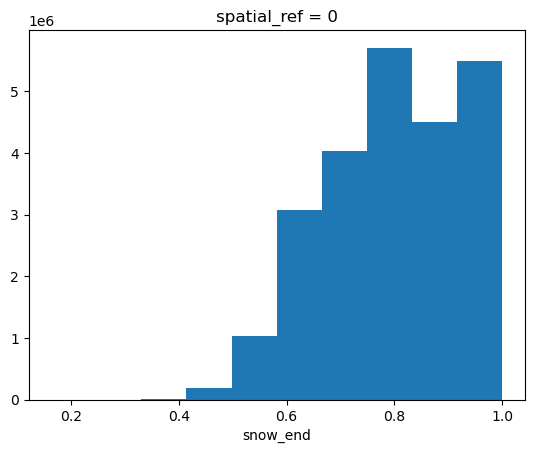

In [26]:
i2_weight.plot.hist()

In [27]:
qw = (u_weight * 0.5) + (i1_weight * 0.25) + (i2_weight * 0.25) # 50% weight for uncertainty, 50% for implausibility
qw

<xarray.DataArray (winterYear: 6, y: 2001, x: 2001)> Size: 192MB
array([[[0.83013898, 0.84038966, 0.83520539, ..., 0.58286167,
         0.58286167, 0.58286167],
        [0.8566774 , 0.8566774 , 0.83520539, ..., 0.59388286,
         0.58286167, 0.58286167],
        [0.8566774 , 0.84038966, 0.83520539, ..., 0.58286167,
         0.58286167, 0.58286167],
        ...,
        [0.91358404, 0.87936277, 0.87936277, ..., 0.90898644,
         0.90898644, 0.90898644],
        [0.87936277, 0.87936277, 0.87936277, ..., 0.90839977,
         0.90839977, 0.90839977],
        [0.87936277, 0.87936277, 0.87936277, ..., 0.90839977,
         0.90839977, 0.90839977]],

       [[0.85859147, 0.85081291, 0.7530458 , ..., 0.79022863,
         0.79022863, 0.79022863],
        [0.83251999, 0.83251999, 0.7530458 , ..., 0.76924479,
         0.79022863, 0.79022863],
        [0.83251999, 0.74984731, 0.7530458 , ..., 0.79022863,
         0.79022863, 0.79022863],
...
        [0.87686896, 0.91853256, 0.82747598, ..., 0.89894764,
         0.89894764, 0.89894764],
        [0.91853256, 0.82747598, 0.82747598, ..., 0.92902171,
         0.92902171, 0.92902171],
        [0.82747598, 0.82747598, 0.82747598, ..., 0.92902171,
         0.92902171, 0.92902171]],

       [[0.85859147, 0.86673617, 0.862617  , ..., 0.81434702,
         0.81434702, 0.81434702],
        [0.88881485, 0.88881485, 0.862617  , ..., 0.80047608,
         0.81434702, 0.81434702],
        [0.88881485, 0.86673617, 0.862617  , ..., 0.81434702,
         0.81434702, 0.81434702],
        ...,
        [0.8645065 , 0.82562047, 0.82562047, ..., 0.84191418,
         0.84191418, 0.84191418],
        [0.82562047, 0.82562047, 0.82562047, ..., 0.81801875,
         0.81801875, 0.81801875],
        [0.82562047, 0.82562047, 0.82562047, ..., 0.81801875,
         0.81801875, 0.81801875]]])
Coordinates:
  * winterYear   (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0

(array([3.0000000e+00, 0.0000000e+00, 8.9200000e+02, 8.2190000e+03,
        1.6982200e+05, 2.7908700e+05, 1.7426350e+06, 1.0718063e+07,
        8.9486370e+06, 2.1566480e+06]),
 array([0.29521547, 0.36569393, 0.43617238, 0.50665083, 0.57712928,
        0.64760774, 0.71808619, 0.78856464, 0.85904309, 0.92952155,
        1.        ]),
 <BarContainer object of 10 artists>)

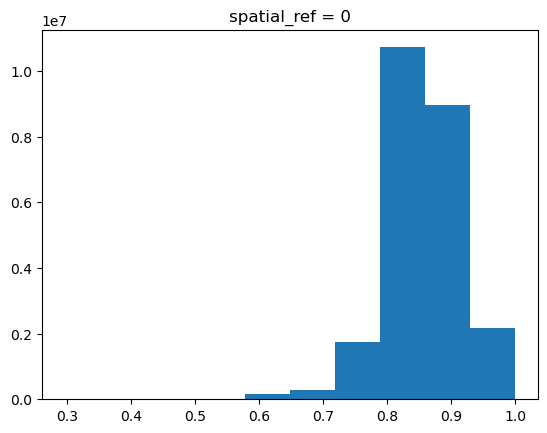

In [28]:
qw.plot.hist()

In [29]:
u_weight[0]

<xarray.DataArray 'snow_end_u' (y: 2001, x: 2001)> Size: 16MB
array([[0.7247224 , 0.7247224 , 0.7247224 , ..., 0.43695977, 0.43695977,
        0.43695977],
       [0.7247224 , 0.7247224 , 0.7247224 , ..., 0.43695977, 0.43695977,
        0.43695977],
       [0.7247224 , 0.7247224 , 0.7247224 , ..., 0.43695977, 0.43695977,
        0.43695977],
       ...,
       [0.87111115, 0.8130371 , 0.8130371 , ..., 0.85130626, 0.85130626,
        0.85130626],
       [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.87111115, 0.87111115,
        0.87111115],
       [0.8130371 , 0.8130371 , 0.8130371 , ..., 0.87111115, 0.87111115,
        0.87111115]], dtype=float32)
Coordinates:
    winterYear   <U9 36B '2018-2019'
  * x            (x) float64 16kB 6.49e+05 6.49e+05 ... 7.089e+05 7.09e+05
  * y            (y) float64 16kB 6.553e+05 6.552e+05 ... 5.953e+05 5.953e+05
    spatial_ref  int64 8B 0

# Plot
- u (weight / days)
- i1 (weight / days)
- i2 (weight / days)

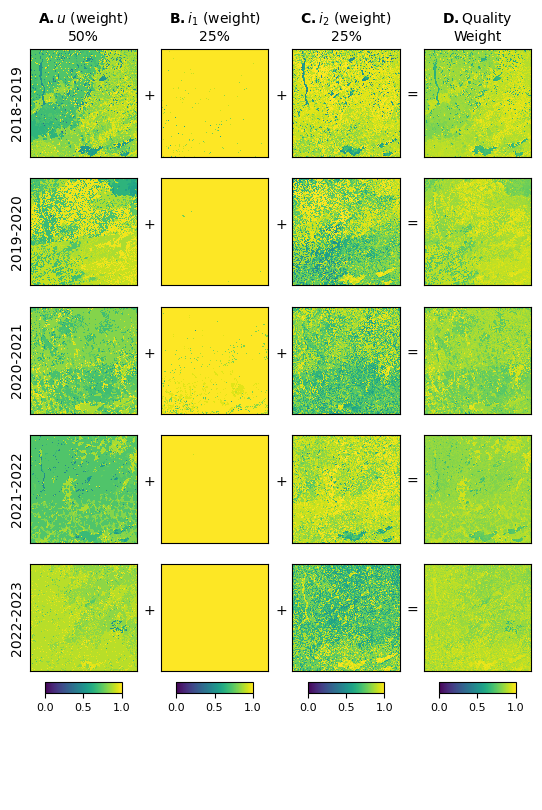

In [31]:
fig = plt.figure(figsize = (6.5, 6.5 * 6/4))

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin = 0, vmax = 1) # 0.5 - 1?

# A. Uncertainty (weight)
# 2018-2019
axA_1819 = plt.subplot2grid((6, 4), (0, 0))

u_weight[0].plot(ax = axA_1819, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axA_1819.set_title('$\\bf{A.}$$\\it{u}$ (weight)\n50%', fontsize = 10)
axA_1819.set_ylabel('2018-2019', fontsize = 10)
axA_1819.set_box_aspect(1)

# 2019-2020
axA_1920 = plt.subplot2grid((6, 4), (1, 0))

u_weight[1].plot(ax = axA_1920, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axA_1920.set_ylabel('2019-2020', fontsize = 10)
axA_1920.set_box_aspect(1)

# 2020-2021
axA_2021 = plt.subplot2grid((6, 4), (2, 0))

u_weight[2].plot(ax = axA_2021, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axA_2021.set_ylabel('2020-2021', fontsize = 10)
axA_2021.set_box_aspect(1)

# 2021-2022
axA_2122 = plt.subplot2grid((6, 4), (3, 0))

u_weight[3].plot(ax = axA_2122, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axA_2122.set_ylabel('2021-2022', fontsize = 10)
axA_2122.set_box_aspect(1)

# 2022-2023
axA_2223 = plt.subplot2grid((6, 4), (4, 0))

u_weight[4].plot(ax = axA_2223, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axA_2223.set_ylabel('2022-2023', fontsize = 10)
axA_2223.set_box_aspect(1)

# Colorbar
axA_cbar = plt.subplot2grid((6, 4), (5, 0))
axA_cbar.set_axis_off()

cax = axA_cbar.inset_axes([0.15, 1, 0.7, 0.1])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, orientation = 'horizontal', extend = 'neither')
cbar.ax.tick_params(labelsize = 8)

# B. Implausibility 1 (weight)
# 2018-2019
axB_1819 = plt.subplot2grid((6, 4), (0, 1))

i1_weight[:, :, 0].plot(ax = axB_1819, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axB_1819.set_title('$\\bf{B.}$$\\it{i_{1}}$ (weight)\n25%', fontsize = 10)
axB_1819.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axB_1819.set_box_aspect(1)

# 2019-2020
axB_1920 = plt.subplot2grid((6, 4), (1, 1))

i1_weight[:, :, 1].plot(ax = axB_1920, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axB_1920.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axB_1920.set_box_aspect(1)

# 2020-2021
axB_2021 = plt.subplot2grid((6, 4), (2, 1))

i1_weight[:, :, 2].plot(ax = axB_2021, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axB_2021.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axB_2021.set_box_aspect(1)

# 2021-2022
axB_2122 = plt.subplot2grid((6, 4), (3, 1))

i1_weight[:, :, 3].plot(ax = axB_2122, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axB_2122.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axB_2122.set_box_aspect(1)

# 2022-2023
axB_2223 = plt.subplot2grid((6, 4), (4, 1))

i1_weight[:, :, 4].plot(ax = axB_2223, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axB_2223.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axB_2223.set_box_aspect(1)

# Colorbar
axB_cbar = plt.subplot2grid((6, 4), (5, 1))
axB_cbar.set_axis_off()

cax = axB_cbar.inset_axes([0.15, 1, 0.7, 0.1])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, orientation = 'horizontal', extend = 'neither')
cbar.ax.tick_params(labelsize = 8)

# C. Implausibility 2 (weight)
# 2018-2019
axC_1819 = plt.subplot2grid((6, 4), (0, 2))

i2_weight[:, :, 0].plot(ax = axC_1819, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axC_1819.set_title('$\\bf{C.}$$\\it{i_{2}}$ (weight)\n25%', fontsize = 10)
axC_1819.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axC_1819.set_box_aspect(1)

# 2019-2020
axC_1920 = plt.subplot2grid((6, 4), (1, 2))

i2_weight[:, :, 1].plot(ax = axC_1920, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axC_1920.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axC_1920.set_box_aspect(1)

# 2020-2021
axC_2021 = plt.subplot2grid((6, 4), (2, 2))

i2_weight[:, :, 2].plot(ax = axC_2021, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axC_2021.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axC_2021.set_box_aspect(1)

# 2021-2022
axC_2122 = plt.subplot2grid((6, 4), (3, 2))

i2_weight[:, :, 3].plot(ax = axC_2122, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axC_2122.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axC_2122.set_box_aspect(1)

# 2022-2023
axC_2223 = plt.subplot2grid((6, 4), (4, 2))

i2_weight[:, :, 4].plot(ax = axC_2223, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axC_2223.set_ylabel('+', fontsize = 10, rotation = 'horizontal', ha = 'right')
axC_2223.set_box_aspect(1)

# Colorbar
axC_cbar = plt.subplot2grid((6, 4), (5, 2))
axC_cbar.set_axis_off()

cax = axC_cbar.inset_axes([0.15, 1, 0.7, 0.1])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, orientation = 'horizontal', extend = 'neither')
cbar.ax.tick_params(labelsize = 8)

# D Quality wieghts
# 2018-2019
axD_1819 = plt.subplot2grid((6, 4), (0, 3))

qw[0].plot(ax = axD_1819, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axD_1819.set_title('$\\bf{D.}$Quality\nWeight', fontsize = 10)
axD_1819.set_ylabel('=', fontsize = 10, rotation = 'horizontal', ha = 'right')
axD_1819.set_box_aspect(1)

# 2019-2020
axD_1920 = plt.subplot2grid((6, 4), (1, 3))

qw[1].plot(ax = axD_1920, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axD_1920.set_ylabel('=', fontsize = 10, rotation = 'horizontal', ha = 'right')
axD_1920.set_box_aspect(1)

# 2020-2021
axD_2021 = plt.subplot2grid((6, 4), (2, 3))

qw[2].plot(ax = axD_2021, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axD_2021.set_ylabel('=', fontsize = 10, rotation = 'horizontal', ha = 'right')
axD_2021.set_box_aspect(1)

# 2021-2022
axD_2122 = plt.subplot2grid((6, 4), (3, 3))

qw[3].plot(ax = axD_2122, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axD_2122.set_ylabel('=', fontsize = 10, rotation = 'horizontal', ha = 'right')
axD_2122.set_box_aspect(1)

# 2022-2023
axD_2223 = plt.subplot2grid((6, 4), (4, 3))

qw[4].plot(ax = axD_2223, add_labels = False, xticks = [], yticks = [], vmin = 0, vmax = 1, cmap = 'viridis', add_colorbar = False)

axD_2223.set_ylabel('=', fontsize = 10, rotation = 'horizontal', ha = 'right')
axD_2223.set_box_aspect(1)

# Colorbar
axD_cbar = plt.subplot2grid((6, 4), (5, 3))
axD_cbar.set_axis_off()

cax = axD_cbar.inset_axes([0.15, 1, 0.7, 0.1])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, orientation = 'horizontal', extend = 'neither')
cbar.ax.tick_params(labelsize = 8)

fig.get_figure().savefig('Figure A13.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})